In [18]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model



In [23]:
BS= 32
TS=(24,24)
train_datagen =image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    'data/train',
    color_mode="grayscale",
    batch_size=BS,
    target_size=TS,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    'data/train', # same directory as training data
    color_mode="grayscale",
    batch_size=BS,
    target_size=TS,
    class_mode='categorical',
    subset='validation') # set as validation data
SPE= len(train_generator.classes)//BS
VS = len(validation_generator.classes)//BS
print(SPE,VS)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
100 25


In [24]:
img,labels= next(train_generator)
print(img.shape)


(32, 24, 24, 1)


In [25]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    MaxPooling2D(pool_size=(1,1)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
#32 convolution filters used each of size 3x3
#again
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1,1)),

#64 convolution filters used each of size 3x3
#choose the best features via pooling
    
#randomly turn neurons on and off to improve convergence
    Dropout(0.25),
#flatten since too many dimensions, we only want a classification output
    Flatten(),
#fully connected to get all relevant data
    Dense(128, activation='relu'),
#one more dropout for convergence' sake :) 
    Dropout(0.5),
#output a softmax to squash the matrix into output probabilities
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 22, 22, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 64)      

In [38]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator,epochs=10)

Epoch 1/2
100/100 [==============================] - 11s 99ms/step - loss: 0.0258 - accuracy: 0.9934 - val_loss: 0.4154 - val_accuracy: 0.9450
Epoch 2/2
100/100 [==============================] - 10s 96ms/step - loss: 0.0039 - accuracy: 0.9981 - val_loss: 0.3530 - val_accuracy: 0.9613


In [28]:
rec=history.history
rec

{'loss': [0.1738656461238861,
  0.04524242505431175,
  0.04882622882723808,
  0.021086925640702248,
  0.016775785014033318,
  0.025660453364253044,
  0.006794984918087721,
  0.009734959341585636,
  0.013330323621630669,
  0.010338430292904377,
  0.001839312957599759,
  0.0037245338317006826,
  0.005824089515954256,
  0.001589385443367064,
  0.022946976125240326],
 'accuracy': [0.9281250238418579,
  0.9834374785423279,
  0.9840624928474426,
  0.9918749928474426,
  0.9934375286102295,
  0.9925000071525574,
  0.9978125095367432,
  0.9962499737739563,
  0.995312511920929,
  0.9956250190734863,
  0.9993749856948853,
  0.9990624785423279,
  0.9987499713897705,
  0.9993749856948853,
  0.9928125143051147],
 'val_loss': [0.14089728891849518,
  0.19752666354179382,
  0.17638908326625824,
  0.20157857239246368,
  0.19215813279151917,
  0.18845587968826294,
  0.2503206431865692,
  0.3384525179862976,
  0.2922976016998291,
  0.4080514907836914,
  0.36260902881622314,
  0.3856480121612549,
  0.45565

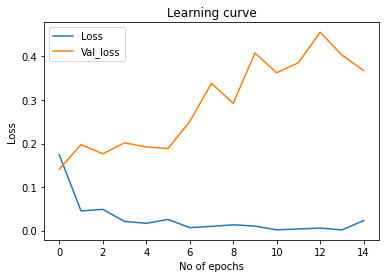

In [32]:
from matplotlib import pyplot as plt

plt.plot(range(15),rec['loss'])
plt.plot(range(15),rec['val_loss'])

plt.legend(["Loss",'Val_loss'])
plt.title("Learning curve")
plt.xlabel("No of epochs")
plt.ylabel("Loss")
plt.show()


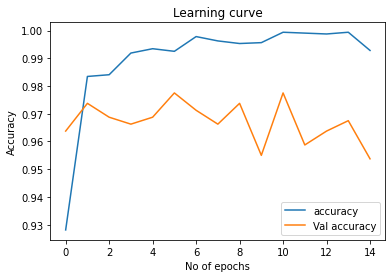

In [35]:
from matplotlib import pyplot as plt

plt.plot(range(15),rec['accuracy'])
plt.plot(range(15),rec['val_accuracy'])

plt.legend(["accuracy","Val accuracy"])
plt.title("Learning curve")
plt.xlabel("No of epochs")
plt.ylabel("Accuracy")
plt.show()

In [39]:
import cv2
import os
from keras.models import load_model
import numpy as np
from pygame import mixer
import time


mixer.init()
sound = mixer.Sound('alarm.wav')

face = cv2.CascadeClassifier('haar cascade files\haarcascade_frontalface_alt.xml')
leye = cv2.CascadeClassifier('haar cascade files\haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('haar cascade files\haarcascade_righteye_2splits.xml')



lbl=['Close','Open']

path = os.getcwd()
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
count=0
score=0
thicc=2
rpred=[99]
lpred=[99]

while(True):
    ret, frame = cap.read()
    height,width = frame.shape[:2] 

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
    left_eye = leye.detectMultiScale(gray)
    right_eye =  reye.detectMultiScale(gray)

    cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED )

    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y) , (x+w,y+h) , (100,100,100) , 1 )

    for (x,y,w,h) in right_eye:
        r_eye=frame[y:y+h,x:x+w]
        count=count+1
        r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        r_eye = cv2.resize(r_eye,(24,24))
        r_eye= r_eye/255
        r_eye=  r_eye.reshape(24,24,-1)
        r_eye = np.expand_dims(r_eye,axis=0)
        rpred = np.argmax(model.predict(r_eye),axis=1)
        if(rpred[0]==1):
            lbl='Open' 
        if(rpred[0]==0):
            lbl='Closed'
        break

    for (x,y,w,h) in left_eye:
        l_eye=frame[y:y+h,x:x+w]
        count=count+1
        l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)  
        l_eye = cv2.resize(l_eye,(24,24))
        l_eye= l_eye/255
        l_eye=l_eye.reshape(24,24,-1)
        l_eye = np.expand_dims(l_eye,axis=0)
        lpred = np.argmax(model.predict(l_eye),axis=1)
        if(lpred[0]==1):
            lbl='Open'   
        if(lpred[0]==0):
            lbl='Closed'
        break

    if(rpred[0]==0 and lpred[0]==0):
        score=score+1
        cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    # if(rpred[0]==1 or lpred[0]==1):
    else:
        score=score-1
        cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
        
    if(score<0):
        score=0   
    cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    if(score>15):
        #person is feeling sleepy so we beep the alarm
        cv2.imwrite(os.path.join(path,'image.jpg'),frame)
        try:
            sound.play()
            
        except:  # isplaying = False
            pass
        if(thicc<16):
            thicc= thicc+2
        else:
            thicc=thicc-2
            if(thicc<2):
                thicc=2
        cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc) 
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


In [2]:
import cv2
import os
from keras.models import load_model
import numpy as np
from pygame import mixer
import time
import tkinter as tk
from PIL import Image, ImageTk

class CameraUI:
    def __init__(self, window):
        self.window = window
        self.window.title("Camera App")

        self.label = tk.Label(self.window)
        self.label.pack()

        self.btn_open = tk.Button(self.window, text="Open Camera", command=self.open_camera)
        self.btn_open.pack()

        self.btn_close = tk.Button(self.window, text="Close Camera", command=self.close_camera, state="disabled")
        self.btn_close.pack()

        self.capture = None

    def open_camera(self):
        mixer.init()
        sound = mixer.Sound('alarm.wav')

        face = cv2.CascadeClassifier('haar cascade files\haarcascade_frontalface_alt.xml')
        leye = cv2.CascadeClassifier('haar cascade files\haarcascade_lefteye_2splits.xml')
        reye = cv2.CascadeClassifier('haar cascade files\haarcascade_righteye_2splits.xml')



        lbl=['Close','Open']

        model = load_model('models/cnncat2.h5')
        path = os.getcwd()
        cap = cv2.VideoCapture(0)
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        count=0
        score=0
        thicc=2
        rpred=[99]
        lpred=[99]

        while(True):
            ret, frame = cap.read()
            height,width = frame.shape[:2] 

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
            left_eye = leye.detectMultiScale(gray)
            right_eye =  reye.detectMultiScale(gray)

            cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED )

            for (x,y,w,h) in faces:
                cv2.rectangle(frame, (x,y) , (x+w,y+h) , (100,100,100) , 1 )

            for (x,y,w,h) in right_eye:
                r_eye=frame[y:y+h,x:x+w]
                count=count+1
                r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
                r_eye = cv2.resize(r_eye,(24,24))
                r_eye= r_eye/255
                r_eye=  r_eye.reshape(24,24,-1)
                r_eye = np.expand_dims(r_eye,axis=0)
                rpred = np.argmax(model.predict(r_eye),axis=1)
                if(rpred[0]==1):
                    lbl='Open' 
                if(rpred[0]==0):
                    lbl='Closed'
                break

            for (x,y,w,h) in left_eye:
                l_eye=frame[y:y+h,x:x+w]
                count=count+1
                l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)  
                l_eye = cv2.resize(l_eye,(24,24))
                l_eye= l_eye/255
                l_eye=l_eye.reshape(24,24,-1)
                l_eye = np.expand_dims(l_eye,axis=0)
                lpred = np.argmax(model.predict(l_eye),axis=1)
                if(lpred[0]==1):
                    lbl='Open'   
                if(lpred[0]==0):
                    lbl='Closed'
                break

            if(rpred[0]==0 and lpred[0]==0):
                score=score+1
                cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
            # if(rpred[0]==1 or lpred[0]==1):
            else:
                score=score-1
                cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
            
                
            if(score<0):
                score=0   
            cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
            if(score>10):
                #person is feeling sleepy so we beep the alarm
                cv2.imwrite(os.path.join(path,'image.jpg'),frame)
                try:
                    sound.play()
                    
                except:  # isplaying = False
                    pass
                if(thicc<16):
                    thicc= thicc+2
                else:
                    thicc=thicc-2
                    if(thicc<2):
                        thicc=2
                cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc) 
            cv2.imshow('frame',frame)

    def close_camera(self):
                    self.capture.release()

                    self.btn_open.config(state="normal")
                    self.btn_close.config(state="disabled")

                    self.window.quit()

    def show_frame(self):
        _, frame = self.capture.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(frame)
        photo = ImageTk.PhotoImage(image=image)

        self.label.config(image=photo)
        self.label.image = photo

        self.window.after(10, self.show_frame)

if __name__ == "__main__":
    root = tk.Tk()
    app = CameraUI(root)
    root.mainloop()


KeyboardInterrupt: 